In [1]:
### Load libraries ###

from Billy.forecastingNN import plotModelGridError, plotModelDiagnosis

# interactive plotting
#%matplotlib inline
%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize': (10, 10), 'figure.dpi': 120})

sns.set(rc={"figure.figsize":(10, 10)})
# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

from sklearn import set_config
set_config(display='diagram')
from neuralsens import partial_derivatives as ns


# Statsmodels time series 
#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime

torch installation could not be found, only numpy activation functions allowed


In [2]:
df2 = pd.read_csv('../data/visits_train.csv', parse_dates=['date_visit'], dayfirst=True)
df = df2.copy()
df['day_of_week'] = df['date_visit'].dt.dayofweek
df['visit_lag7'] = df['visits'].shift(7)
df.day_of_week = df.day_of_week.astype('category')
df.location = df.location.astype('category')
df = df.dropna().reset_index(drop=True)
df

,location,date_visit,visits,day_of_week,visit_lag7
0,Madrid,2023-02-21,66.369096,1,67.323720
1,Madrid,2023-02-20,67.536579,0,71.894430
2,Madrid,2023-02-19,81.202408,6,87.803810
3,Madrid,2023-02-18,89.925916,5,90.435243
4,Madrid,2023-02-17,70.986109,4,76.281122
...,...,...,...,...,...
1326,Barcelona,2021-05-05,43.053853,2,45.000342
1327,Barcelona,2021-05-04,44.398808,1,26.111127
1328,Barcelona,2021-05-03,47.631696,0,52.399008
1329,Barcelona,2021-05-02,25.857399,6,0.000000


In [3]:
#estos son los dias que han sido festivos en españa en 2021, 2022 y 2023 en Madrid 
festivos = ['2021-01-01', '2021-01-06', '2021-03-19','2021-04-01', '2021-04-02',  '2021-05-01', '2021-05-03', '2021-05-15', '2021-10-12', '2021-11-01', '2021-11-09','2021-12-06', '2021-12-08', '2021-12-25', 
            '2022-01-01', '2022-01-06', '2022-04-14', '2022-05-16', '2022-05-02', '2022-07-25','2022-08-15', '2022-10-12', '2022-11-01', '2022-11-09', '2022-12-06', '2022-12-08', '2022-12-26', 
            '2023-01-06', '2023-03-20']

#Barcelona
festivos2 = ['2021-01-01', '2021-01-06', '2021-04-02', '2021-04-05',  '2021-05-01',  '2021-05-24',  '2021-06-24',  '2021-09-11', '2021-09-24', '2021-10-12', '2021-11-01','2021-12-06', '2021-12-08', '2021-12-25',
             '2022-01-01', '2022-01-06', '2022-04-15', '2022-04-18', '2022-06-06', '2022-06-24','2022-08-15',  '2022-09-24', '2022-09-26', '2022-10-12', '2022-11-01', '2022-12-06', '2022-12-08', '2022-12-26',
             '2023-01-06']
df['festivo'] = 0

festivos = pd.to_datetime(festivos)
festivos2 = pd.to_datetime(festivos2)
for location, festivos_loc in [('Madrid', festivos), ('Barcelona', festivos2)]:
    for festivo in festivos_loc:
        df.loc[df['date_visit'] == festivo, 'festivo'] = 1
df.festivo = df.festivo.astype('category')
df

,location,date_visit,visits,day_of_week,visit_lag7,festivo
0,Madrid,2023-02-21,66.369096,1,67.323720,0
1,Madrid,2023-02-20,67.536579,0,71.894430,0
2,Madrid,2023-02-19,81.202408,6,87.803810,0
3,Madrid,2023-02-18,89.925916,5,90.435243,0
4,Madrid,2023-02-17,70.986109,4,76.281122,0
...,...,...,...,...,...,...
1326,Barcelona,2021-05-05,43.053853,2,45.000342,0
1327,Barcelona,2021-05-04,44.398808,1,26.111127,0
1328,Barcelona,2021-05-03,47.631696,0,52.399008,1
1329,Barcelona,2021-05-02,25.857399,6,0.000000,0


In [4]:
INPUTS = ['date_visit','day_of_week','location','visit_lag7','festivo']
OUTPUT = 'visits'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS]
y = df[OUTPUT]

In [5]:
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]



## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['visits'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['visits'] = y_test

X_train.head()

,date_visit,day_of_week,location,visit_lag7,festivo
0,2023-02-21,1,Madrid,67.323720,0
1,2023-02-20,0,Madrid,71.894430,0
2,2023-02-19,6,Madrid,87.803810,0
3,2023-02-18,5,Madrid,90.435243,0
4,2023-02-17,4,Madrid,76.281122,0


In [14]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['visit_lag7']
INPUTS_MLP_CAT = ['day_of_week','festivo', 'location'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

param = {'MLP__alpha': [0.00001,0.0001,0.001,0.01], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(25,),(50,50,),(50,50,60,),(50,50,70,),(50,50,80,),(50,50,90,),(50,50,100,),(100,100,100,),
                                    (5,),(10,),(15,),(20,),(50,10),(50,15),(50,20),(50,25),(50,30),(50,35),(50,40),(50,45),
                                    ]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='adam', # Update function
                activation='relu', # Logistic sigmoid activation function
                max_iter=900, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

Iteration 1, loss = 1985.28533776
Iteration 2, loss = 1981.77130723
Iteration 3, loss = 1977.83278357
Iteration 4, loss = 1973.32610890
Iteration 5, loss = 1967.84313715
Iteration 6, loss = 1961.49391311
Iteration 7, loss = 1954.22172063
Iteration 8, loss = 1945.93665456
Iteration 9, loss = 1936.61804206
Iteration 10, loss = 1926.05700823
Iteration 11, loss = 1913.97551777
Iteration 12, loss = 1900.05170486
Iteration 13, loss = 1883.80053077
Iteration 14, loss = 1864.87432667
Iteration 15, loss = 1843.10339186
Iteration 16, loss = 1817.48410984
Iteration 17, loss = 1786.77066385
Iteration 18, loss = 1750.67955829
Iteration 19, loss = 1709.25398419
Iteration 20, loss = 1661.91477883
Iteration 21, loss = 1607.62139763
Iteration 22, loss = 1545.73573630
Iteration 23, loss = 1475.37038255
Iteration 24, loss = 1396.61287542
Iteration 25, loss = 1310.10584504
Iteration 26, loss = 1216.80847147
Iteration 27, loss = 1114.40220873
Iteration 28, loss = 1005.10110501
Iteration 29, loss = 889.0215

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['visit_lag7']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['festivo',
                                                                          'location'])])),
                                       ('MLP',
                                        MLPRegressor(max_iter=900,
                                                     random_state=150,
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [1e-05, 0.0001, 0.001, 0.01],
                         'MLP__hidden_layer_sizes': [(25,), (6, 6, 6),
                                                     (10, 10, 10),
                                                     (15, 15, 15)]},
             scoring='neg_mean_squared_error')

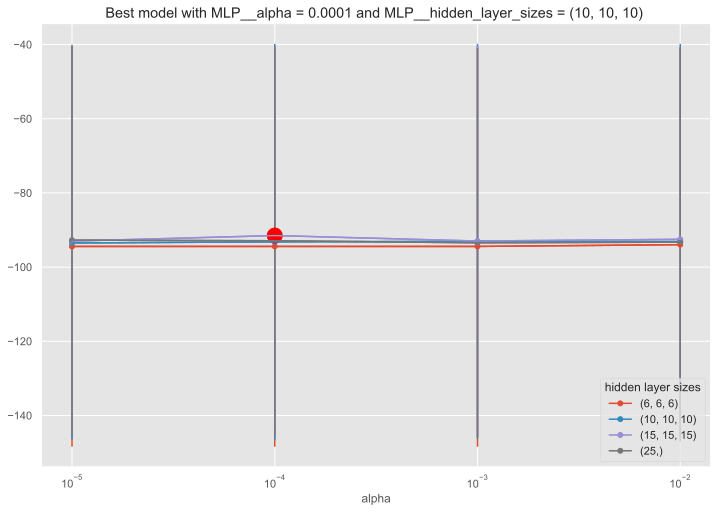

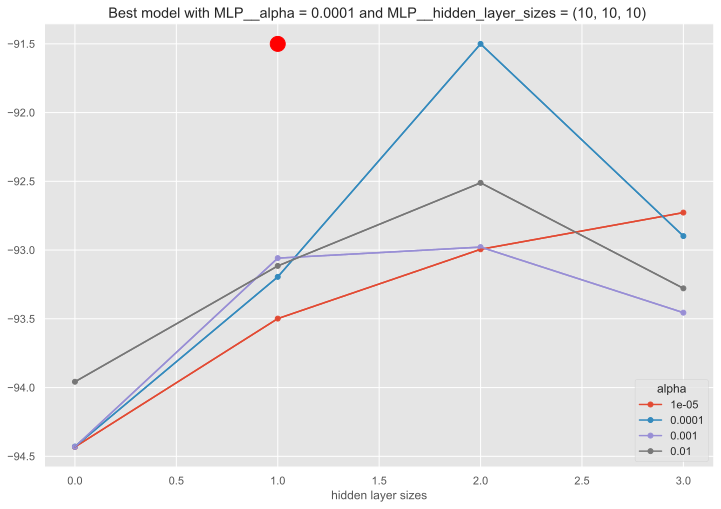

In [15]:
plotModelGridError(MLP_fit, xscale="log")

In [16]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['visits'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['visits'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['visits'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['visits'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['visits'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['visits'], dfTS_eval['MLP_pred']))

Training MAE: 5.212979300505487
Test MAE: 6.211003003827731
Training RMSE: 9.091456749446232
Test RMSE: 11.290417034050613
Training R2: 0.6208355486612789
Test R2: 0.37653191414856535


<Axes: >

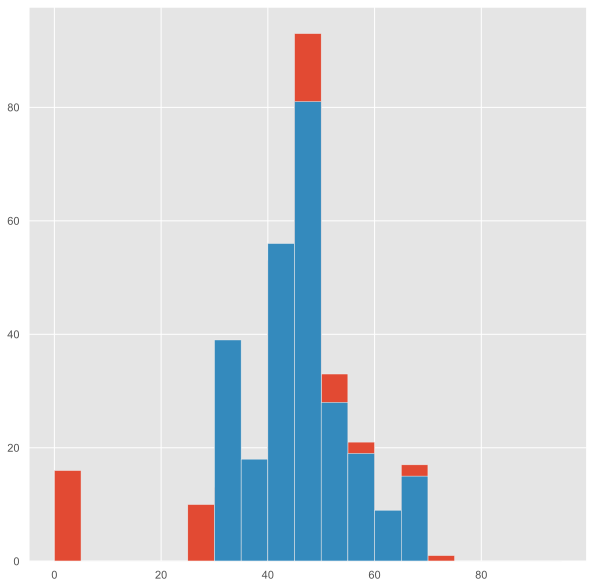

In [17]:
bins = np.arange(0,100,5)
dfTS_eval.visits.hist(bins   = bins)
dfTS_eval.MLP_pred.hist(bins = bins)

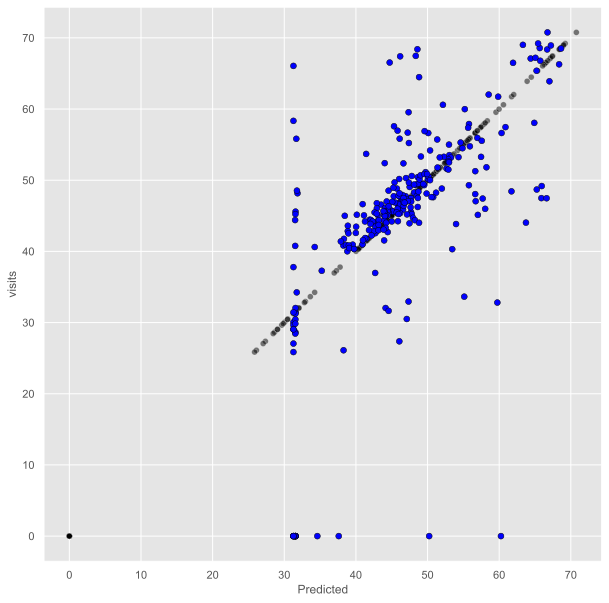

In [18]:
sns.scatterplot(data=dfTS_eval, x='visits', y='visits', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='visits', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

In [19]:
nList = []
fM=[]
fBcn=[]
X_val = pd.DataFrame()
X_val_mad = pd.DataFrame()
X_val_bcn = pd.DataFrame()
for i in range(1,32):
    l = pd.to_datetime(f'2023-03-{i}')
    nList.append(l)
    if l in festivos:
        fBcn.append(1)
        
        if l in festivos2:
            fM.append(1)
        else:
            fM.append(0)
    else:
        if l in festivos2:
            fM.append(1)
        else:
            fM.append(0)
            fBcn.append(0)
        
            
X_val_mad['date_visit'] = nList
X_val_bcn['date_visit'] = nList

X_val_mad['day_of_week']=X_val_mad['date_visit'].dt.dayofweek
X_val_bcn['day_of_week']=X_val_bcn['date_visit'].dt.dayofweek

X_val_mad['location'] = 'Madrid'
X_val_mad['festivo'] = fM

X_val_bcn['location'] = 'Barcelona'
X_val_bcn['festivo'] = fBcn

In [20]:

u7M = df.visits[df.location == 'Madrid'].iloc[-8:-1].tolist()
u7B = df.visits[df.location == 'Barcelona'].iloc[-8:-1].tolist()

X_val_mad['visit_lag7'] = np.append(u7M, np.zeros(24))
X_val_bcn['visit_lag7'] = np.append(u7B, np.zeros(24))

v7M = MLP_fit.predict(X_val_mad.iloc[0:7])
v7B = MLP_fit.predict(X_val_bcn.iloc[0:7])

X_val_mad['visits']=np.append(v7M,np.zeros(24))
X_val_bcn['visits']=np.append(v7B,np.zeros(24))

X_val_mad['visit_lag7'] = np.append(np.append(u7B,v7B),np.zeros(17))
X_val_bcn['visit_lag7'] = np.append(np.append(u7M,v7M),np.zeros(17))

v7M = MLP_fit.predict(X_val_mad.iloc[0:14])
v7B = MLP_fit.predict(X_val_bcn.iloc[0:14])



X_val_mad['visits']=np.append(v7M,np.zeros(17))
X_val_bcn['visits']=np.append(v7B,np.zeros(17))

X_val_mad['visit_lag7'] = np.append(np.append(u7M,v7M),np.zeros(10))
X_val_bcn['visit_lag7'] = np.append(np.append(u7B,v7B),np.zeros(10))

v7M = MLP_fit.predict(X_val_mad.iloc[0:21])
v7B = MLP_fit.predict(X_val_bcn.iloc[0:21])



X_val_mad['visits']=np.append(v7M,np.zeros(10))
X_val_bcn['visits']=np.append(v7B,np.zeros(10))

X_val_mad['visit_lag7'] = np.append(np.append(u7M,v7M),np.zeros(3))
X_val_bcn['visit_lag7'] = np.append(np.append(u7B,v7B),np.zeros(3))

v7M = MLP_fit.predict(X_val_mad.iloc[0:28])
v7B = MLP_fit.predict(X_val_bcn.iloc[0:28])


X_val_mad['visits']=np.append(v7M,np.zeros(3))
X_val_bcn['visits']=np.append(v7B,np.zeros(3))

X_val_mad['visit_lag7'] =np.append(u7B,v7B)[0:31]
X_val_bcn['visit_lag7'] =np.append(u7M,v7M)[0:31]

v7M = MLP_fit.predict(X_val_mad)
v7B = MLP_fit.predict(X_val_bcn)

X_val_mad['visits']=v7M
X_val_bcn['visits']=v7B

X_val_mad['date_visit'] = pd.to_datetime(X_val_mad['date_visit'], format = '%y-%m-%d)')
X_val_bcn['date_visit'] = pd.to_datetime(X_val_bcn['date_visit'], format = '%y-%m-%d)')

X_val_mad['location_date']=X_val_mad.apply(lambda x: x['location'] + '_' + str(x['date_visit']), axis = 1)
X_val_bcn['location_date']=X_val_bcn.apply(lambda x: x['location'] + '_' + str(x['date_visit']), axis = 1)

In [21]:

X_val = pd.concat([X_val_bcn,X_val_mad], ignore_index=True)
X_val[['location_date', 'visits']].to_csv('../data/pred.csv', sep = ',', index = False)